In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
import string
import spacy
from nltk.corpus import stopwords
from ruts import MorphStats, ReadabilityStats, DiversityStats

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style='whitegrid', palette='Set2')
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Data Preprocessing

In [5]:
def to_sentiment(score):
    score = int(score)
    if score < 6:
        return 0
    elif score < 8:
        return 1
    else:
        return 2

In [ ]:
def smoothing_target_encoder(df, column, target, weight=100):
    mean = df[target].mean()
    agg = df.groupby(column)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + weight * mean) / (counts + weight)
    return df[column].map(smooth)

In [6]:
def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma_.lower().strip() for word in doc if not word.is_digit]
    tokens = [word for word in tokens if word not in STOPWORDS and word not in PUNCTUATIONS]
    return ' '.join(tokens)

In [7]:
def get_text_stats(text):
    rs = ReadabilityStats(text)
    stats['flesch_kincaid_grade'] = rs.flesch_kincaid_grade
    stats['flesch_reading_easy'] = rs.flesch_reading_easy
    stats['coleman_liau_index'] = rs.coleman_liau_index
    stats['smog_index'] = rs.smog_index
    stats['automated_readability_index'] = rs.automated_readability_index
    stats['lix'] = rs.lix
    ds = DiversityStats(text)
    stats['ttr'] = ds.ttr
    stats['mattr'] = ds.mattr
    stats['msttr'] = ds.msttr
    stats['mtld'] = ds.mtld
    stats['mamtld'] = ds.mamtld
    return stats

In [8]:
PUNCTUATIONS = string.punctuation + '–«»“”...'
STOPWORDS = stopwords.words('russian')
nlp = spacy.load('/media/archive/Data Science/NLP/Models/spacy-ru')
nlp.disable_pipes('ner')

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f993cedee88>)]

In [5]:
df = pd.read_json('../data/reviews.json')
df.head()

,valuation,title,description,authors,editors,date,comments,visual_overview,platforms,developers,...,score,laugh,joy,disgust,surprise,anger,bitterness,interest,poker,url
0,14,Picklock,История о профессиональном домушнике,Александр Логинов (xtr),Михаил Шагинян (ACE)\nДенис Королев (SkyerIst),2020-05-18 00:21:00,1,управление через жопу\nЭксклюзив\nОднообразнос...,PC,Deqaf Studio,...,6,0,1,0,7,0,1,2,3,https://gamemag.ru/reviews/picklock-pc
1,13,Filament,Исследуем звездолет и решаем загадки,Александр Логинов (xtr),Михаил Шагинян (ACE)\nДенис Королев (SkyerIst),2020-05-20 22:31:00,5,Атмосфера - она обволакивает и поглощает\ndlc\...,SWITCH\nPC,Beard Envy,...,8,0,3,0,5,0,0,5,0,https://gamemag.ru/reviews/filament-pc
2,12,HyperParasite,Проникаем в тело президента США,Александр Логинов (xtr),Михаил Шагинян (ACE)\nДенис Королев (SkyerIst),2020-05-19 22:31:00,3,dlc\nшансы что вам понравится близки к нулю\nО...,SWITCH\nPS4\nONE\nPC,Troglobytes Games,...,6,0,1,1,10,0,0,0,0,https://gamemag.ru/reviews/hyperparasite
3,47,Valorant,Тактический шутер для киберспорта,Алексей Сарафанов (ASarafanov),Михаил Шагинян (ACE)\nДенис Королев (SkyerIst),2020-06-14 18:47:00,13,Аддиктивный геймплей\nКрутой герой\ndlc\nЭкскл...,PC,Riot Games,...,8,1,8,23,7,0,0,4,4,https://gamemag.ru/reviews/valorant-pc
4,0,Valley,"Интересные идеи, но неудачная реализация",Александр Логинов (xtr),Михаил Шагинян (ACE)\nДенис Королев (SkyerIst),2016-08-28 21:52:00,4,Атмосфера - она обволакивает и поглощает\ndlc\...,PS4\nONE\nPC,Blue Isle Studios,...,6,0,0,0,0,0,0,0,0,https://gamemag.ru/reviews/valley


In [61]:
df['sentiment'] = df.score.apply(to_sentiment)

In [62]:
df['sentiment'].value_counts()

1    671
2    656
0    212
Name: sentiment, dtype: int64

In [54]:
df = pd.concat([df, df.apply(lambda row: get_text_stats(row.text), axis=1, result_type='expand')], axis=1)

In [65]:
%time
df['text'] = df['text'].apply(preprocess_text)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [23]:
df['theme'] = df.theme.apply(lambda x: 1 if x == 'есть' else 0)

In [108]:
df['developers'] = LabelEncoder().fit_transform(df['developers'])
df['developers'] = smoothing_target_encoder(df, column='developers', target='sentiment')

In [109]:
df['publishers'] = LabelEncoder().fit_transform(df['publishers'])
df['publishers'] = smoothing_target_encoder(df, column='publishers', target='sentiment')

In [110]:
df['authors'] = LabelEncoder().fit_transform(df['authors'])
df['authors'] = smoothing_target_encoder(df, column='authors', target='sentiment')

In [111]:
df['duration'] = LabelEncoder().fit_transform(df['duration'].fillna('Нет'))
df['duration'] = smoothing_target_encoder(df, column='duration', target='sentiment')

In [112]:
df['passed_on'] = LabelEncoder().fit_transform(df['passed_on'])
df['passed_on'] = smoothing_target_encoder(df, column='passed_on', target='sentiment')

In [24]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['weekday'] = df.date.dt.weekday

In [73]:
df = df.join(df.visual_overview.str.split('\n', expand=True) \
   .stack() \
   .str.get_dummies() \
   .sum(level=0))

In [74]:
df = df.join(df.platforms.str.split('\n', expand=True) \
   .stack() \
   .str.get_dummies() \
   .sum(level=0))

In [75]:
df = df.join(df.genres.str.split('\n', expand=True) \
   .stack() \
   .str.get_dummies() \
   .sum(level=0))

In [158]:
X = df.drop('sentiment', axis=1)
y = df['sentiment']

In [159]:
df.to_pickle('../data/reviews.pkl')

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 2. Text Classification

In [14]:
def train(model, X, y, params):
    pipe = Pipeline([
        ('vectorizer', tfidf_vect),
        ('classifier', model)
    ])
    scoring = ['accuracy', 'f1_macro']
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)
    grid = GridSearchCV(
        pipe,
        params,
        scoring=f1,
        n_jobs=-1,
        cv=kfold,
        verbose=2
    )
    return grid.fit(X, y)

In [15]:
f1 = make_scorer(f1_score, average='weighted')

In [16]:
tfidf_vect = TfidfVectorizer(max_features=5000)

In [112]:
X_train_text = X_train['text']
X_test_text = X_test['text']

## 2.1. Logistic Regression

In [113]:
lr_clf = LogisticRegression(
    solver='liblinear',
    verbose=0,
    n_jobs=-1,
    random_state=777
)

In [114]:
params = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(0, 4, 10)
}

In [115]:
result = train(lr_clf, X_train_text, y_train, params)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   34.7s finished
/home/sergio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sergio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [116]:
result.best_score_, result.best_params_

(0.6052666756609995,
 {'classifier__C': 7.742636826811269,
  'classifier__penalty': 'l1',
  'vectorizer__ngram_range': (1, 1)})

In [130]:
y_pred = result.predict(X_test_text)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.6898872276024836


In [ ]:
lr_clf = result.best_estimator_['classifier']

## 2.2. Naive Bayes

In [131]:
nb_clf = MultinomialNB()

In [132]:
params = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_features': range(1000, 10000, 1000),
    'vectorizer__analyzer': ['word', 'char']
}

In [133]:
result = train(nb_clf, X_train_text, y_train, params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   35.5s finished


In [134]:
result.best_score_, result.best_params_

(0.5556118120404083,
 {'vectorizer__analyzer': 'word',
  'vectorizer__max_features': 3000,
  'vectorizer__ngram_range': (1, 1)})

In [135]:
y_pred = result.predict(X_test_text)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.5887588869187118


/home/sergio/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
nb_clf = result.best_estimator_['classifier']

## 2.3. SVM

In [139]:
svc_clf = SVC(probability=True)

In [140]:
params = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__C': np.logspace(0, 4, 10)
}

In [141]:
result = train(svc_clf, X_train_text, y_train, params)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.5min finished


In [142]:
result.best_score_, result.best_params_

(0.6284530850169618,
 {'classifier__C': 2.7825594022071245,
  'classifier__kernel': 'linear',
  'vectorizer__ngram_range': (1, 2)})

In [143]:
y_pred = result.predict(X_test_text)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.6597986078154129


In [144]:
svc_clf = result.best_estimator_['classifier']

## 2.4. Ensemble

In [145]:
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]

In [146]:
classifiers = [
    ('lr', lr_clf),
    ('nb', nb_clf),
    ('svc', svc_clf),
]

In [147]:
params = {
    'voting__weights': combinations_on_off(len(classifiers))
}

In [148]:
mixed_pipe = Pipeline([
    ('vectorizer', tfidf_vect),
    ('voting', VotingClassifier(classifiers, voting="soft"))
])

In [150]:
scoring = ['accuracy', 'f1_macro']
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)
grid = GridSearchCV(
    mixed_pipe,
    params,
    scoring=f1,
    n_jobs=-1,
    cv=kfold,
    verbose=2
)
result = grid.fit(X_train_text, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   48.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   48.6s finished
/home/sergio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sergio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [151]:
result.best_score_, result.best_params_

(0.6232507018062543, {'voting__weights': [0, 0, 1]})

In [152]:
y_pred = result.predict(X_test_text)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.6792048015622406


# 3. Numerical Classification

In [27]:
def train(model, X, y, params):
    scoring = ['accuracy', 'f1_macro']
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)
    grid = GridSearchCV(
        model,
        params,
        scoring=f1,
        n_jobs=-1,
        cv=kfold,
        verbose=2
    )
    return grid.fit(X, y)

In [162]:
def plot_importance(model, X, title, file, num=40):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0: num])
    plt.title(title)
    plt.tight_layout()
    plt.savefig(file)
    plt.show()

In [29]:
f1 = make_scorer(f1_score, average='weighted')

In [30]:
non_numeric = ['visual_overview',
                 'platforms', 
                 'genres', 
                 'date', 
                 'editors',
                 'verdict',
                 'title',
                 'url',
                 'description',
                 'duration',
                 'passed_on',
                 'text',
                 'score'
              ]

In [109]:
X_train_num = X_train.drop(non_numeric, axis=1)
X_test_num = X_test.drop(non_numeric, axis=1)

## LightGBM

In [129]:
lgb_clf = LGBMClassifier(
    verbose=0,
    n_jobs=-1,
    random_state=777,
    importance_type='gain'
)

In [130]:
params = {
    'classifier__n_estimators': range(100, 500, 100),
    'classifier__max_depth': range(3, 10, 2)
}

In [131]:
result = train(lgb_clf, X_train_num, y_train, params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    6.5s finished


In [132]:
result.best_score_, result.best_params_

(0.8501821257431141,
 {'classifier__max_depth': 3, 'classifier__n_estimators': 100})

In [133]:
y_pred = result.predict(X_test_num)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.8397342157160702


In [134]:
lgb_clf = result.best_estimator_

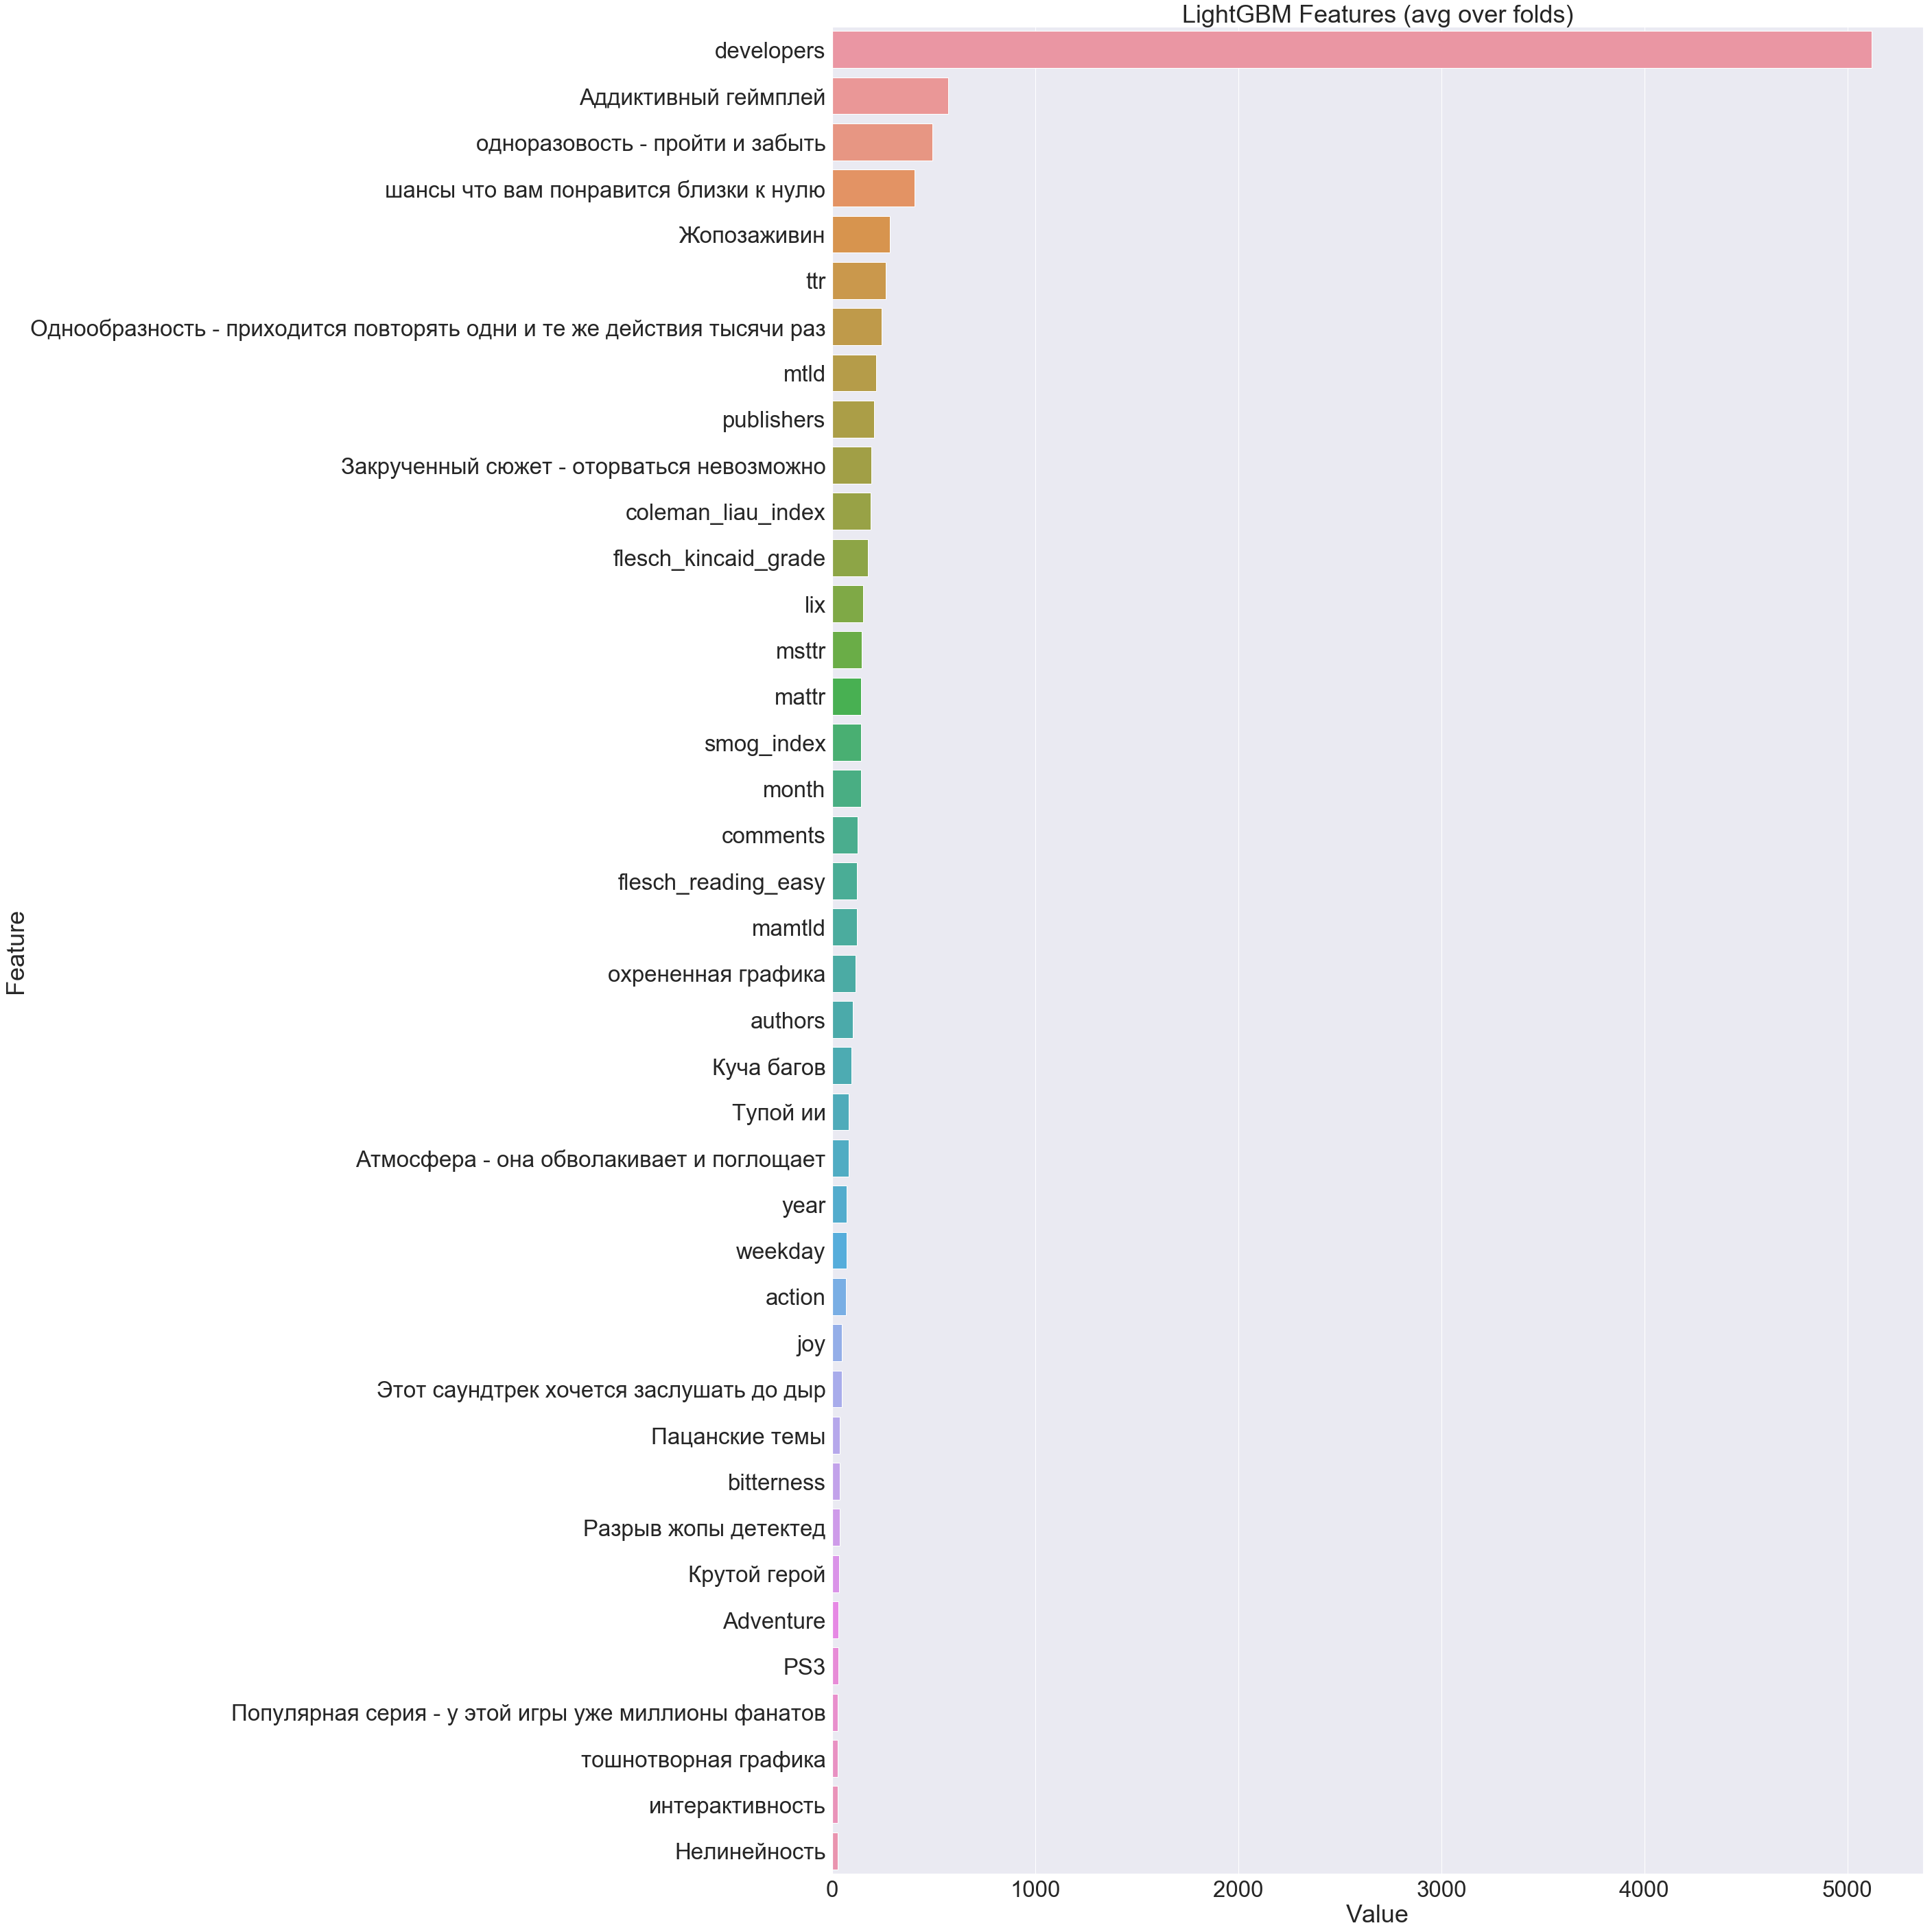

In [163]:
plot_importance(lgb_clf, 
                X_train_num,
                "LightGBM Features (avg over folds)",
                "lgbm_importances.png"
               )

## XGBoost

In [136]:
xgb_clf = XGBClassifier(
    n_jobs=-1,
    random_state=777
)

In [137]:
params = {
    'classifier__n_estimators': range(100, 500, 100),
    'classifier__max_depth': range(3, 10, 2)
}

In [138]:
result = train(xgb_clf, X_train_num, y_train, params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.0s finished


In [139]:
result.best_score_, result.best_params_

(0.8490214888415778,
 {'classifier__max_depth': 3, 'classifier__n_estimators': 100})

In [140]:
y_pred = result.predict(X_test_num)
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted')}")

F1-score: 0.8205962218856688


In [141]:
xgb_clf = result.best_estimator_

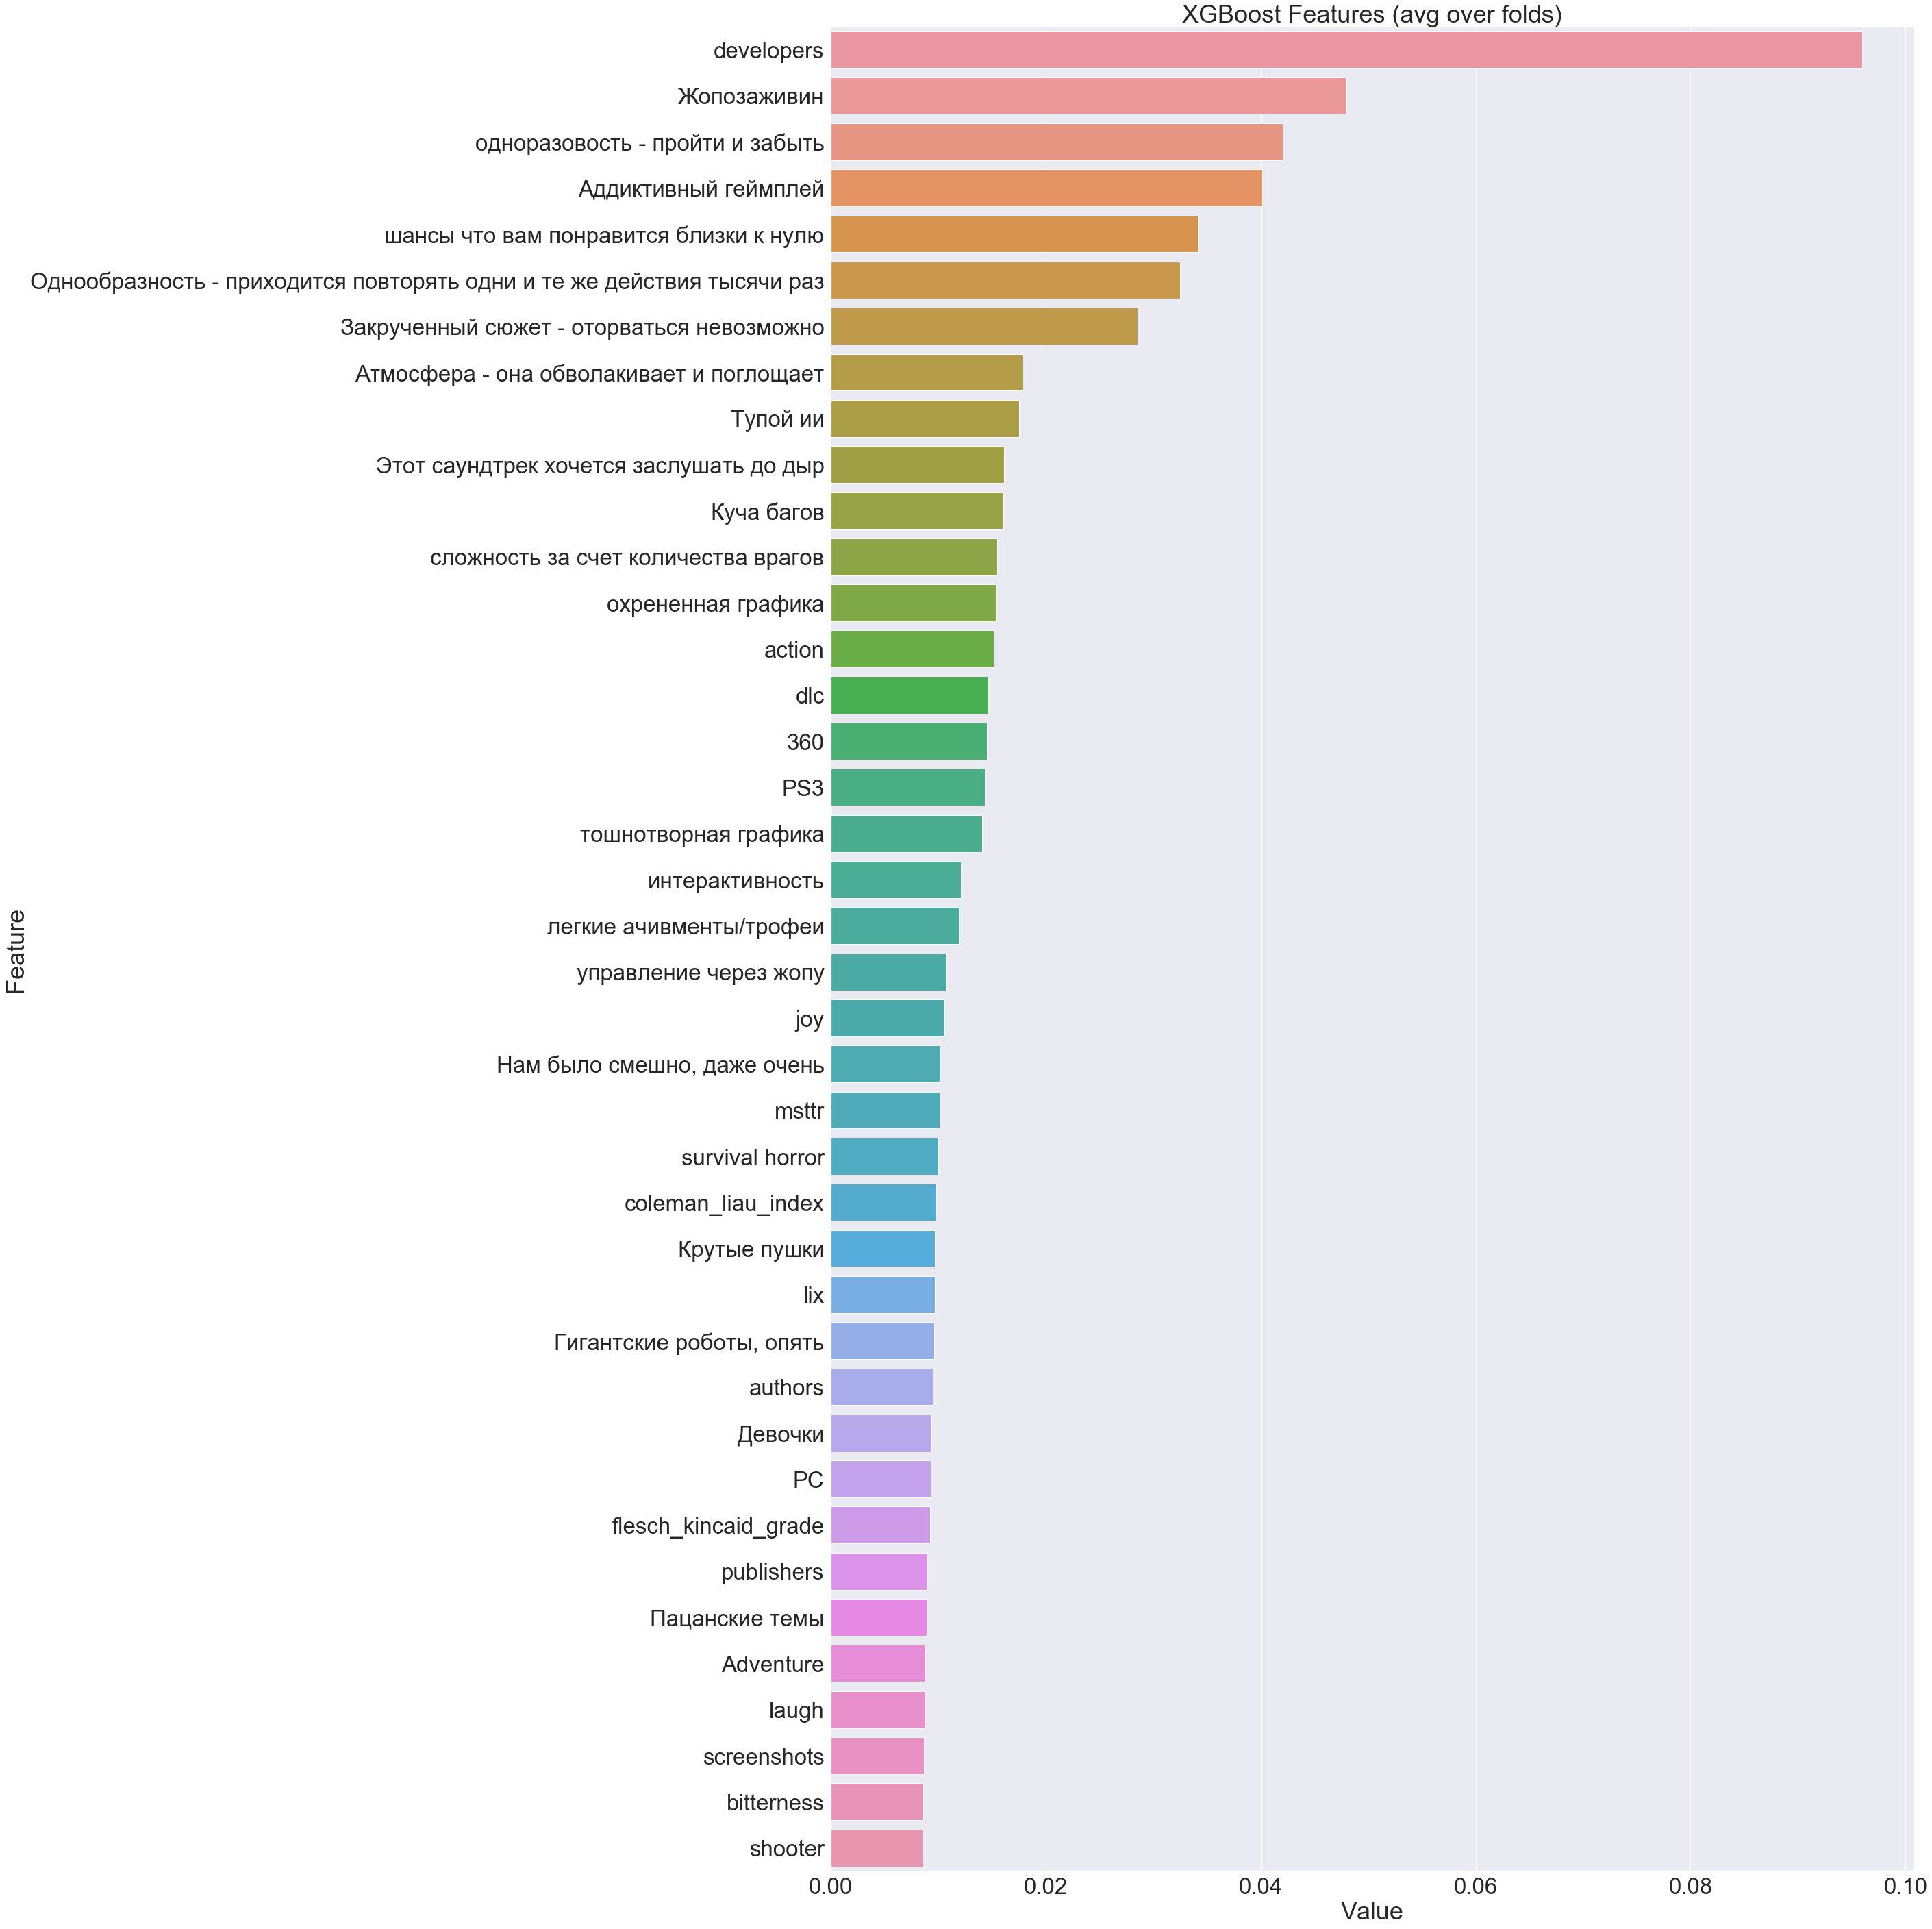

In [164]:
plot_importance(xgb_clf, 
                X_train_num,
                "XGBoost Features (avg over folds)",
                "xgb_importances.png"
               )